# Применение решающих деревьев для прогнозирования ( с нормированными данными )


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [11]:
def smape(A, F):
    return 100*np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

## подготовка данных

In [12]:
df = pd.read_csv("https://video.ittensive.com/time-series/ittensive.time.series.04.csv", encoding="windows-1251",
                   delimiter=";", decimal=",", header=0) 
df.columns = list(map(lambda x: x.lower(),(['Дата','Открытие','Макс','Мин','цена'])))
df


,дата,открытие,макс,мин,цена
0,03.01.2020,255.99,258.19,253.70,255.00
1,06.01.2020,254.75,254.84,251.40,253.90
2,08.01.2020,253.57,259.15,253.03,259.15
3,09.01.2020,259.40,261.76,257.01,257.99
4,10.01.2020,257.86,259.25,256.88,258.19
...,...,...,...,...,...
627,27.12.2021,294.76,296.00,293.37,295.59
628,28.12.2021,295.84,297.55,294.18,294.98
629,29.12.2021,295.05,295.55,291.33,293.37
630,30.12.2021,293.60,294.89,291.52,293.39


Аугментация 

Приведем дату к дате, выделим дни недели, добавим 4 предыдущих значения и рассчитаем 5 производных

In [13]:
df["дата"] = pd.to_datetime((df["дата"]))
df["wd"] = df["дата"].dt.weekday
df["diff1"] = df["цена"].diff()
for i in range(1, 5):
    df["цена" + str(i)] = df["цена"].shift(i)
    df["diff" + str(i+1)] = df["diff" + str(i)].diff()
df.head()

,дата,открытие,макс,мин,цена,wd,diff1,цена1,diff2,цена2,diff3,цена3,diff4,цена4,diff5
0,2020-03-01,255.99,258.19,253.70,255.00,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-01,254.75,254.84,251.40,253.90,0,-1.10,255.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-08-01,253.57,259.15,253.03,259.15,5,5.25,253.90,6.35,255.00,NaN,NaN,NaN,NaN,NaN
3,2020-09-01,259.40,261.76,257.01,257.99,1,-1.16,259.15,-6.41,253.90,-12.76,255.0,NaN,NaN,NaN
4,2020-10-01,257.86,259.25,256.88,258.19,3,0.20,257.99,1.36,259.15,7.77,253.9,20.53,255.0,NaN


In [14]:
cols = df.columns
cols

Index(['дата', 'открытие', 'макс', 'мин', 'цена', 'wd', 'diff1', 'цена1',
       'diff2', 'цена2', 'diff3', 'цена3', 'diff4', 'цена4', 'diff5'],
      dtype='object')

Отнормируем данные

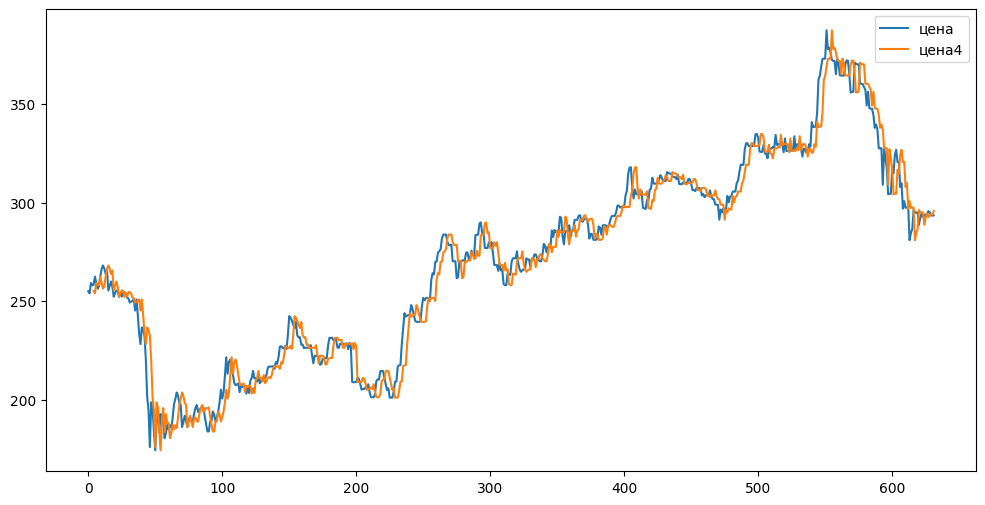

In [15]:
plcols = ['цена', 'цена4']
plt.figure(figsize=(12, 6))
plt.plot(list(df[plcols[0]]))
plt.plot(list(df[plcols[1]]))
plt.legend(labels=[plcols[0], plcols[1]])
plt.show()        

In [16]:
x_columns = [ 'открытие', 'макс', 'мин', 'цена2', 'цена3', 'цена4', 'wd', 'diff1', 'diff2', 'diff3', 'diff4', 'diff5']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[x_columns][5:])

## Находим корреляцию параметров

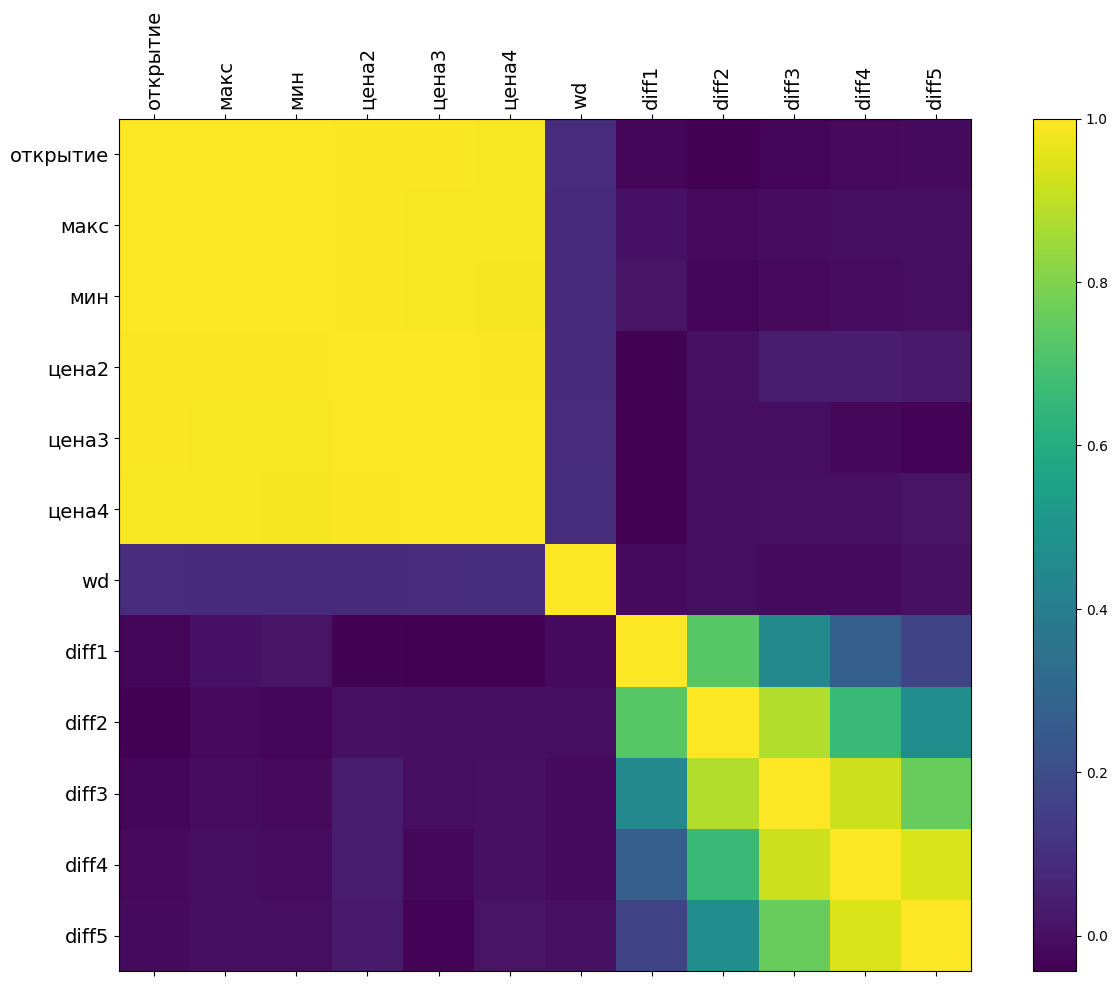

In [17]:
f = plt.figure(figsize=(16, 11))
data_corr = pd.DataFrame(data_scaled).corr()
plt.matshow(data_corr, fignum=f.number)
plt.xticks(range(len(x_columns)), x_columns, fontsize=14, rotation=90)
plt.yticks(range(len(x_columns)), x_columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.show()

In [18]:
feature_list = []
for i,c in enumerate(data_corr[0]):
    if (c>0.5 or c<-0.5) and i>0:
        feature_list.append(x_columns[i])
print ("Перспективные факторы: " + ', '.join(feature_list))

Перспективные факторы: макс, мин, цена2, цена3, цена4


## Обучение модели

In [20]:
data = df.copy()
feature_list = x_columns

scaler_x = StandardScaler()
scaler_y = StandardScaler()
x = scaler_x.fit_transform(data[feature_list][5:-7])
y = scaler_y.fit_transform(np.array(data["цена"][5:-7]).reshape(-1, 1))
model = CatBoostRegressor(iterations=300, depth=16, verbose=True).fit(x, y)

Learning rate set to 0.101036
0:	learn: 0.9292897	total: 1.79s	remaining: 8m 56s
1:	learn: 0.8669281	total: 3.62s	remaining: 9m
2:	learn: 0.7967639	total: 5.39s	remaining: 8m 54s
3:	learn: 0.7480588	total: 7.17s	remaining: 8m 50s
4:	learn: 0.6913499	total: 9.07s	remaining: 8m 55s
5:	learn: 0.6432256	total: 10.9s	remaining: 8m 53s
6:	learn: 0.6008373	total: 12.7s	remaining: 8m 53s
7:	learn: 0.5660268	total: 14.5s	remaining: 8m 47s
8:	learn: 0.5220484	total: 16.3s	remaining: 8m 47s
9:	learn: 0.4841314	total: 18.2s	remaining: 8m 46s
10:	learn: 0.4568460	total: 20s	remaining: 8m 46s
11:	learn: 0.4264402	total: 22s	remaining: 8m 46s
12:	learn: 0.4044843	total: 24s	remaining: 8m 48s
13:	learn: 0.3815933	total: 25.9s	remaining: 8m 49s
14:	learn: 0.3597800	total: 27.9s	remaining: 8m 49s
15:	learn: 0.3361281	total: 29.8s	remaining: 8m 48s
16:	learn: 0.3159973	total: 31.7s	remaining: 8m 47s
17:	learn: 0.2962130	total: 33.8s	remaining: 8m 49s
18:	learn: 0.2729516	total: 33.8s	remaining: 8m 19s
19

155:	learn: 0.0089872	total: 5m 47s	remaining: 5m 20s
156:	learn: 0.0088610	total: 5m 50s	remaining: 5m 18s
157:	learn: 0.0087055	total: 5m 52s	remaining: 5m 16s
158:	learn: 0.0085956	total: 5m 55s	remaining: 5m 14s
159:	learn: 0.0084980	total: 5m 57s	remaining: 5m 12s
160:	learn: 0.0084077	total: 5m 59s	remaining: 5m 10s
161:	learn: 0.0083110	total: 6m 2s	remaining: 5m 8s
162:	learn: 0.0082002	total: 6m 4s	remaining: 5m 6s
163:	learn: 0.0081077	total: 6m 7s	remaining: 5m 4s
164:	learn: 0.0079829	total: 6m 9s	remaining: 5m 2s
165:	learn: 0.0078958	total: 6m 11s	remaining: 5m
166:	learn: 0.0078107	total: 6m 14s	remaining: 4m 58s
167:	learn: 0.0077205	total: 6m 16s	remaining: 4m 56s
168:	learn: 0.0076054	total: 6m 19s	remaining: 4m 53s
169:	learn: 0.0075298	total: 6m 21s	remaining: 4m 51s
170:	learn: 0.0074319	total: 6m 24s	remaining: 4m 50s
171:	learn: 0.0073678	total: 6m 26s	remaining: 4m 47s
172:	learn: 0.0072590	total: 6m 29s	remaining: 4m 45s
173:	learn: 0.0072067	total: 6m 31s	rema

## Визуализация результата

In [21]:
x_test = scaler_x.fit_transform(data[feature_list][-120:])
y_test = data["цена"][-120:]
forecast = scaler_y.inverse_transform(np.array(model.predict(x_test)).reshape(-1, 1))

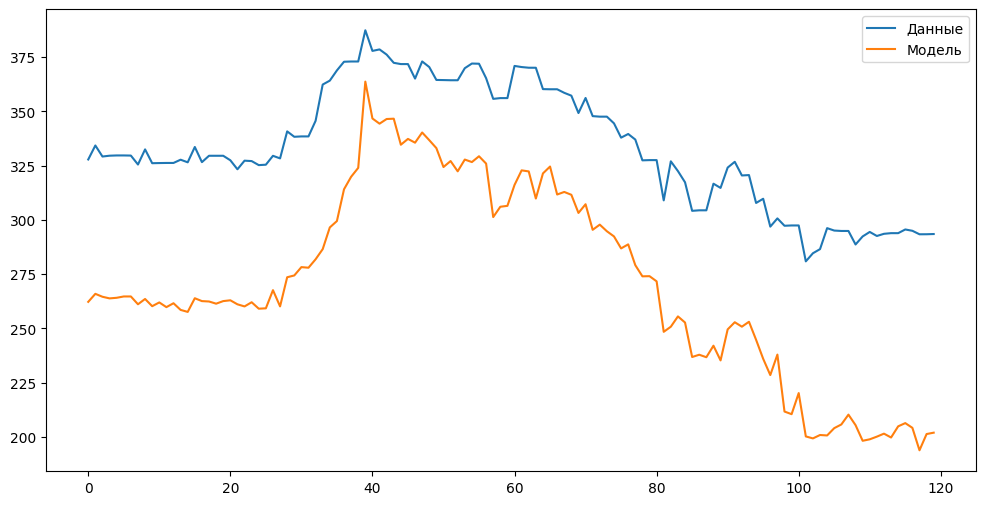

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(list(y_test))
plt.plot(forecast)
plt.legend(labels=["Данные", "Модель"])
plt.show()

Оценим ошибку

In [23]:
model_smape = smape(list(y_test[-24:]), forecast[-24:])
print ("Ошибка модели:", model_smape)

Ошибка модели: 20196.69192998939


Ошибка слишком большая.  **Вывод: Решающие деревья плохо подходят для данной задачи. Из ансамбля исключены**